In [211]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import natsort
import re
#We gebruiken de from ... import voor commando's die we veel gebruiken om repititie te verminderen 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from zipfile import ZipFile
import tensorflow as tf

UPLOAD EERST DE DATA ZIP in COLAB, ANDERS KAN HET VOLGENDE BLOK CODE DEZE NIET UITPAKKEN

In [212]:
standaarddirectory = os.getcwd()                  #standaarddirectory van google colab opslaan zodat we altijd terug kunnen keren naar deze
file_name = "delay_dataset.zip"                   
if not os.path.exists("stud_train"):              #Als de data nog niet uitgepakt is en deze folder dus nog niet bestaat, gaan we dit doen
  with ZipFile(file_name,'r') as zipper:
    zipper.extractall()
    print("extractie data klaar")

if not os.path.exists("stud_train_combined_ASDR"):    #Een folder waarin we de gecombineerde ASDR train signalen van 1024 samples zullen opslaan
  os.makedirs("stud_train_combined_ASDR")
if not os.path.exists("stud_train_combined_GAUSS"):   #Een folder waarin we de gecombineerde GAUSS train signalen van 1024 samples zullen opslaan
  os.makedirs("stud_train_combined_GAUSS")
if not os.path.exists("stud_train_combined_SBOX"):    #Een folder waarin we de gecombineerde SBOX train signalen van 1024 samples zullen opslaan
  os.makedirs("stud_train_combined_SBOX")

if not os.path.exists("stud_test_combined_ASDR"):    #Een folder waarin we de gecombineerde ASDR test signalen van 1024 samples zullen opslaan
  os.makedirs("stud_test_combined_ASDR")
if not os.path.exists("stud_test_combined_GAUSS"):   #Een folder waarin we de gecombineerde GAUSS test signalen van 1024 samples zullen opslaan
  os.makedirs("stud_test_combined_GAUSS")
if not os.path.exists("stud_test_combined_SBOX"):    #Een folder waarin we de gecombineerde SBOX test signalen van 1024 samples zullen opslaan
  os.makedirs("stud_test_combined_SBOX")

In [213]:
# variable declaration
train_set = 'stud_train'
test_set = 'stud_test'
delaypiekASDR = []    #array met actuele delays tussen de pieken (validatiecijfers voor training)
delaypiekGAUSS = []
delaypiekSBOX = []
delaypiekASDRtest = []    #array met actuele delays tussen de pieken (cijfers voor testing)
delaypiekGAUSStest = []
delaypiekSBOXtest = []

In [214]:
#Geeft een array met strings weer waarin de namen van de files in die map staan
def laadarraymetfilenamenuitmap(map):
    filenames = os.listdir(map)  # array met alle filenames van in folder
    filenames.sort()
    return filenames

In [215]:
#plot het signaal van een numpy array aan de hand van een megegeven signaalbestandsnaam
#Functie werd enkel gebruikt in het begin, niet meer relevant op het einde
def plotsignaal(signaal, evencheck, nummer, x = np.arange(0,512)): #signaal is naam bestand tussen aanhalingstekens
    if evencheck % 2 == 0:
        kleur = "red"         #paar van signalen respectievelijk rood en blauw weergeven zodat het verschil duidelijk is
    else:
        kleur = "blue"
    plot = plt.figure(nummer)
    plt.xlabel("X axis")
    plt.ylabel("Y axis")
    plt.plot(x,np.load(signaal), color=kleur)

In [216]:
#Geeft de waarde van de positie van die piek terug aan de hand van de bestandsnaam
def geefpositiepiek(signaal):
  truncatedsignaal = (signaal.split("P_",1)[1]) #alles voor de xxx wegdoen dus BV ASDR_P_ wegdoen
  piek = ''.join(x for x in truncatedsignaal[0:3] if x.isdigit()) 
  return piek

In [217]:
#voegt de array van twee signalen samen om 1 vector van 1024 samples te bekomen
def voegsamen(signaal1, signaal2):
  return np.concatenate([np.load(signaal1), np.load(signaal2)])

In [218]:
#wordt gebruikt om de lijst met de files te sorten op numerische orde ipv alfabetische orde om sortering van 0 1 10 11 ... 19 2 20 21 ... 29 3 30 31 etc te voorkomen maar 0 1 2 3 4 ... 99
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [219]:
def combinedata(folder, dir, delayarray, typesignaal = "", testoftrain = "", aantalgrafiekenplotten = 0):
  i = 0
  nummer = 1
  evencheck = 0
  x = np.arange(0, 1024)
  k = 0
  for data in folder:
    evencheck += 1
    if k != 0 and evencheck % 2 == 0:
      os.chdir(f"stud_{testoftrain}")
      masterfile = voegsamen(previous, data)
      os.chdir(standaarddirectory)

      os.chdir(dir)
      savename = f"{nummer}{typesignaal}.npy"
      np.save(savename,masterfile)
      os.chdir(standaarddirectory)
      nummer += 1
      delayarray.append(512-int(geefpositiepiek(previous))+int(geefpositiepiek(data)))

      #plotten voor eerste paar grafieken, mooie visualisatie als controle
      if evencheck < ((aantalgrafiekenplotten*2)+1):  #evencheck > aantal grafieken*2, max 41 vanwege memory limiet -> 20 grafieken, zet op 1 indien je geen grafieken wil zien
        plot= plt.figure(nummer)
        plt.plot(x,masterfile, color="red")

    k += 1
    previous = data

END OF FUNCTIONS

In [220]:
#main
#filenames inlezen
filenames = laadarraymetfilenamenuitmap(train_set)
filenamesASDR = filenames[0:200]
filenamesGAUSS = filenames[200:400]
filenamesSBOX = filenames[400:600]

filenamestest = laadarraymetfilenamenuitmap(test_set)
filenamesASDRtest = filenamestest[0:200]
filenamesGAUSStest = filenamestest[200:400]
filenamesSBOXtest = filenamestest[400:600]

#sorteren
filenamesASDR.sort(key=natural_keys)
filenamesGAUSS.sort(key=natural_keys)
filenamesSBOX.sort(key=natural_keys)
filenamesASDRtest.sort(key=natural_keys)
filenamesGAUSStest.sort(key=natural_keys)
filenamesSBOXtest.sort(key=natural_keys)

In [221]:
os.chdir(standaarddirectory)
combinedata(filenamesASDR, "stud_train_combined_ASDR", delaypiekASDR, "ASDR", "train")
combinedata(filenamesGAUSS, "stud_train_combined_GAUSS", delaypiekGAUSS, "GAUSS", "train")
combinedata(filenamesSBOX, "stud_train_combined_SBOX", delaypiekSBOX, "SBOX", "train")

combinedata(filenamesASDRtest, "stud_test_combined_ASDR", delaypiekASDRtest, "ASDR", "test")
combinedata(filenamesGAUSStest, "stud_test_combined_GAUSS", delaypiekGAUSStest, "GAUSS", "test")
combinedata(filenamesSBOXtest, "stud_test_combined_SBOX", delaypiekSBOXtest, "SBOX", "test")

In [222]:
#TENSOR Object maken voor x waarden NN training
os.chdir(standaarddirectory)
os.chdir("stud_train_combined_ASDR")

samplesASDR = [np.load(f"{x}ASDR.npy") for x in range(1, 101)]
samplesASDR = tf.convert_to_tensor(samplesASDR)

os.chdir(standaarddirectory)

In [223]:
#TENSOR Object maken voor x waarden NN testing
os.chdir(standaarddirectory)
os.chdir("stud_test_combined_ASDR")

samplesASDRtest = [np.load(f"{x}ASDR.npy") for x in range(1, 101)]
samplesASDRtest = tf.convert_to_tensor(samplesASDRtest)

os.chdir(standaarddirectory)

In [224]:
#TENSOR object maken voor y waarden NN training
delayASDR = pd.DataFrame(data = delaypiekASDR)
delayASDR = tf.convert_to_tensor(delayASDR)

In [225]:
#Model aanmaken
modelASDR = tf.keras.Sequential()
modelASDR.add(layers.Dense(512, activation='relu', input_shape=(1024,)))
modelASDR.add(layers.Dense(256, activation='relu'))
modelASDR.add(layers.Dense(64, activation='relu'))
modelASDR.add(layers.Dense(8, activation='relu'))
modelASDR.add(layers.Dense(1))

In [226]:
modelASDR.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 512)               524800    
                                                                 
 dense_46 (Dense)            (None, 256)               131328    
                                                                 
 dense_47 (Dense)            (None, 64)                16448     
                                                                 
 dense_48 (Dense)            (None, 8)                 520       
                                                                 
 dense_49 (Dense)            (None, 1)                 9         
                                                                 
Total params: 673,105
Trainable params: 673,105
Non-trainable params: 0
_________________________________________________________________


In [227]:
#Optimizer, loss function en metrics toevoegen aan model en compileren
modelASDR.compile(optimizer='adam', loss='mae', metrics=['mae'])

In [228]:
#Model Trainen
history = modelASDR.fit(samplesASDR,
                        delayASDR,
                        epochs=20)

Epoch 1/20
4/4 [==============================] - 1s 12ms/step - loss: 575.9672 - mae: 575.9672
Epoch 2/20
4/4 [==============================] - 0s 14ms/step - loss: 574.0468 - mae: 574.0468
Epoch 3/20
4/4 [==============================] - 0s 12ms/step - loss: 568.9058 - mae: 568.9058
Epoch 4/20
4/4 [==============================] - 0s 12ms/step - loss: 556.7255 - mae: 556.7255
Epoch 5/20
4/4 [==============================] - 0s 18ms/step - loss: 530.4521 - mae: 530.4521
Epoch 6/20
4/4 [==============================] - 0s 13ms/step - loss: 475.9617 - mae: 475.9617
Epoch 7/20
4/4 [==============================] - 0s 12ms/step - loss: 372.3934 - mae: 372.3934
Epoch 8/20
4/4 [==============================] - 0s 13ms/step - loss: 193.9824 - mae: 193.9824
Epoch 9/20
4/4 [==============================] - 0s 13ms/step - loss: 112.9060 - mae: 112.9060
Epoch 10/20
4/4 [==============================] - 0s 12ms/step - loss: 151.2928 - mae: 151.2928
Epoch 11/20
4/4 [======================

In [229]:
predictionsASDR = modelASDR.predict(samplesASDRtest)

4/4 [==============================] - 0s 7ms/step


[110, 28, 73, 25, 38, 61, 159, 58, 5, 85, 88, 91, 16, 153, 52, 202, 129, 18, 27, 71, 34, 205, 53, 123, 3, 36, 71, 172, 147, 42, 32, 42, 64, 59, 45, 20, 30, 85, 42, 115, 14, 9, 0, 35, 77, 24, 16, 38, 40, 38, 79, 51, 151, 21, 153, 30, 54, 47, 94, 23, 11, 144, 95, 47, 5, 126, 30, 134, 22, 48, 116, 86, 46, 170, 91, 65, 123, 30, 88, 1, 156, 106, 26, 48, 77, 68, 135, 60, 75, 14, 17, 7, 77, 131, 112, 147, 39, 176, 167, 41]
[487.1886901855469, 633.9544677734375, 479.2278747558594, 624.2672119140625, 596.7825927734375, 498.67657470703125, 722.4243774414062, 601.31787109375, 565.1651000976562, 457.2361145019531, 523.2810668945312, 659.3826904296875, 554.5609741210938, 420.6766052246094, 609.0721435546875, 744.3640747070312, 478.4376220703125, 528.535888671875, 560.0279541015625, 647.433349609375, 554.6103515625, 393.98028564453125, 660.5733642578125, 474.6591491699219, 551.1536865234375, 511.4915771484375, 540.6839599609375, 736.7825927734375, 695.896240234375, 591.1578979492188, 577.70458984375

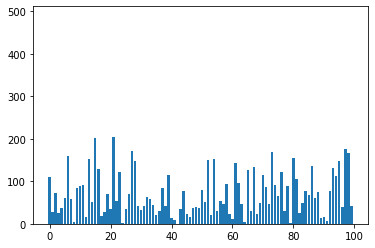

In [230]:
predictionslistASDR = predictionsASDR.tolist()
predictionslistASDRflat = [item for sublist in predictionslistASDR for item in sublist]

error_list_ASDR = []   #absolute waarde van de fout van predictie 
for error1, error2 in zip(predictionslistASDRflat, delaypiekASDRtest):
  error_list_ASDR.append(round(abs(error1 - error2)))

print(error_list_ASDR)
print(predictionslistASDRflat)
print(delaypiekASDRtest)
#visualiseren error
bar = plt.figure(1)
plt.bar(np.arange(0, 100), error_list_ASDR)
plt.ylim(0, 512)
plt.show()


GAUSS MODEL

In [231]:
#TENSOR Object maken voor x waarden NN training
os.chdir(standaarddirectory)
os.chdir("stud_train_combined_GAUSS")

samplesGAUSS = [np.load(f"{x}GAUSS.npy") for x in range(1, 101)]
samplesGAUSS = tf.convert_to_tensor(samplesGAUSS)

os.chdir(standaarddirectory)

In [232]:
#TENSOR Object maken voor x waarden NN testing
os.chdir(standaarddirectory)
os.chdir("stud_test_combined_GAUSS")

samplesGAUSStest = [np.load(f"{x}GAUSS.npy") for x in range(1, 101)]
samplesGAUSStest = tf.convert_to_tensor(samplesGAUSStest)

os.chdir(standaarddirectory)

In [233]:
#TENSOR object maken voor y waarden NN training
delayGAUSS = pd.DataFrame(data = delaypiekGAUSS)
delayGAUSS = tf.convert_to_tensor(delayGAUSS)

In [234]:
#Model aanmaken
modelGAUSS = tf.keras.Sequential()
modelGAUSS.add(layers.Dense(512, activation='relu', input_shape=(1024,)))
modelGAUSS.add(layers.Dense(256, activation='relu'))
modelGAUSS.add(layers.Dense(64, activation='relu'))
modelGAUSS.add(layers.Dense(8, activation='relu'))
modelGAUSS.add(layers.Dense(1))

In [235]:
modelGAUSS.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 512)               524800    
                                                                 
 dense_51 (Dense)            (None, 256)               131328    
                                                                 
 dense_52 (Dense)            (None, 64)                16448     
                                                                 
 dense_53 (Dense)            (None, 8)                 520       
                                                                 
 dense_54 (Dense)            (None, 1)                 9         
                                                                 
Total params: 673,105
Trainable params: 673,105
Non-trainable params: 0
_________________________________________________________________


In [236]:
#Optimizer, loss function en metrics toevoegen aan model en compileren
modelGAUSS.compile(optimizer='adam', loss='mae', metrics=['mae'])

In [237]:
#Model Trainen
history = modelGAUSS.fit(samplesGAUSS,
                        delayGAUSS,
                        epochs=20)

Epoch 1/20
4/4 [==============================] - 1s 10ms/step - loss: 562.4729 - mae: 562.4729
Epoch 2/20
4/4 [==============================] - 0s 10ms/step - loss: 467.7227 - mae: 467.7227
Epoch 3/20
4/4 [==============================] - 0s 9ms/step - loss: 219.6691 - mae: 219.6691
Epoch 4/20
4/4 [==============================] - 0s 9ms/step - loss: 145.6384 - mae: 145.6384
Epoch 5/20
4/4 [==============================] - 0s 8ms/step - loss: 48.3933 - mae: 48.3933
Epoch 6/20
4/4 [==============================] - 0s 9ms/step - loss: 87.0739 - mae: 87.0739
Epoch 7/20
4/4 [==============================] - 0s 9ms/step - loss: 45.0571 - mae: 45.0571
Epoch 8/20
4/4 [==============================] - 0s 9ms/step - loss: 32.2127 - mae: 32.2127
Epoch 9/20
4/4 [==============================] - 0s 8ms/step - loss: 44.4025 - mae: 44.4025
Epoch 10/20
4/4 [==============================] - 0s 14ms/step - loss: 34.7698 - mae: 34.7698
Epoch 11/20
4/4 [==============================] - 0s 8ms/

In [238]:
predictionsGAUSS = modelGAUSS.predict(samplesGAUSStest)

4/4 [==============================] - 0s 4ms/step


[2, 1, 10, 1, 18, 2, 9, 3, 8, 15, 5, 41, 7, 1, 6, 8, 17, 32, 5, 0, 0, 10, 6, 2, 26, 12, 5, 21, 20, 9, 46, 3, 2, 14, 0, 2, 4, 38, 2, 2, 17, 2, 1, 8, 3, 23, 15, 118, 695, 18, 7, 5, 15, 11, 214, 2, 0, 2, 11, 13, 12, 66, 16, 16, 5, 21, 13, 46, 9, 34, 3, 3, 21, 4, 6, 9, 2, 1, 5, 13, 21, 24, 14, 10, 9, 13, 22, 14, 7, 1, 31, 4, 9, 2, 21, 49, 4, 22, 2, 19]
[554.1075439453125, 590.3285522460938, 562.6302490234375, 602.6194458007812, 572.0950927734375, 558.4306030273438, 605.9019775390625, 556.7297973632812, 619.4215698242188, 570.839599609375, 574.1253051757812, 615.9678955078125, 582.26513671875, 605.6973266601562, 599.3956298828125, 580.1568603515625, 604.19775390625, 580.1697998046875, 560.2581787109375, 609.259765625, 604.2094116210938, 614.882568359375, 569.3184814453125, 560.82568359375, 584.445068359375, 559.33837890625, 595.7899169921875, 585.1990966796875, 627.226318359375, 563.9940795898438, 590.69775390625, 563.0178833007812, 601.8990478515625, 572.8333740234375, 583.3443603515625, 6

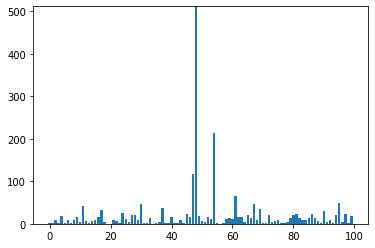

In [239]:
predictionslistGAUSS = predictionsGAUSS.tolist()
predictionslistGAUSSflat = [item for sublist in predictionslistGAUSS for item in sublist]

error_list_GAUSS = []   #absolute waarde van de fout van predictie 
for error1, error2 in zip(predictionslistGAUSSflat, delaypiekGAUSStest):
  error_list_GAUSS.append(round(abs(error1 - error2)))

print(error_list_GAUSS)
print(predictionslistGAUSSflat)
print(delaypiekGAUSStest)
#visualiseren error
bar = plt.figure(2)
plt.bar(np.arange(0, 100), error_list_GAUSS)
plt.ylim(0, 512)
plt.show()


SBOX MODEL

In [240]:
#TENSOR Object maken voor x waarden NN training
os.chdir(standaarddirectory)
os.chdir("stud_train_combined_SBOX")

samplesSBOX = [np.load(f"{x}SBOX.npy") for x in range(1, 101)]
samplesSBOX = tf.convert_to_tensor(samplesSBOX)

os.chdir(standaarddirectory)

In [241]:
#TENSOR Object maken voor x waarden NN testing
os.chdir(standaarddirectory)
os.chdir("stud_test_combined_SBOX")

samplesSBOXtest = [np.load(f"{x}SBOX.npy") for x in range(1, 101)]
samplesSBOXtest = tf.convert_to_tensor(samplesSBOXtest)

os.chdir(standaarddirectory)

In [242]:
#TENSOR object maken voor y waarden NN training
delaySBOX = pd.DataFrame(data = delaypiekSBOX)
delaySBOX = tf.convert_to_tensor(delaySBOX)

In [243]:
#Model aanmaken
modelSBOX = tf.keras.Sequential()
modelSBOX.add(layers.Dense(512, activation='relu', input_shape=(1024,)))
modelSBOX.add(layers.Dense(256, activation='relu'))
modelSBOX.add(layers.Dense(64, activation='relu'))
modelSBOX.add(layers.Dense(8, activation='relu'))
modelSBOX.add(layers.Dense(1))

In [244]:
modelSBOX.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_55 (Dense)            (None, 512)               524800    
                                                                 
 dense_56 (Dense)            (None, 256)               131328    
                                                                 
 dense_57 (Dense)            (None, 64)                16448     
                                                                 
 dense_58 (Dense)            (None, 8)                 520       
                                                                 
 dense_59 (Dense)            (None, 1)                 9         
                                                                 
Total params: 673,105
Trainable params: 673,105
Non-trainable params: 0
_________________________________________________________________


In [245]:
#Optimizer, loss function en metrics toevoegen aan model en compileren
modelSBOX.compile(optimizer='adam', loss='mae', metrics=['mae'])

In [246]:
#Model Trainen
history = modelSBOX.fit(samplesSBOX,
                        delaySBOX,
                        epochs=20)

Epoch 1/20
4/4 [==============================] - 1s 9ms/step - loss: 577.7251 - mae: 577.7251
Epoch 2/20
4/4 [==============================] - 0s 10ms/step - loss: 558.8918 - mae: 558.8918
Epoch 3/20
4/4 [==============================] - 0s 8ms/step - loss: 514.6859 - mae: 514.6859
Epoch 4/20
4/4 [==============================] - 0s 8ms/step - loss: 426.1385 - mae: 426.1385
Epoch 5/20
4/4 [==============================] - 0s 8ms/step - loss: 265.7321 - mae: 265.7321
Epoch 6/20
4/4 [==============================] - 0s 8ms/step - loss: 90.8355 - mae: 90.8355
Epoch 7/20
4/4 [==============================] - 0s 10ms/step - loss: 146.8036 - mae: 146.8036
Epoch 8/20
4/4 [==============================] - 0s 8ms/step - loss: 75.9005 - mae: 75.9005
Epoch 9/20
4/4 [==============================] - 0s 8ms/step - loss: 91.4087 - mae: 91.4087
Epoch 10/20
4/4 [==============================] - 0s 9ms/step - loss: 77.6669 - mae: 77.6669
Epoch 11/20
4/4 [==============================] - 0s 8

In [247]:
predictionsSBOX = modelSBOX.predict(samplesSBOXtest)

4/4 [==============================] - 0s 4ms/step


[51, 97, 19, 24, 75, 104, 75, 10, 58, 11, 78, 2, 21, 30, 31, 36, 54, 42, 45, 5, 71, 53, 22, 15, 48, 72, 8, 38, 42, 38, 14, 51, 17, 51, 35, 45, 64, 51, 13, 18, 62, 49, 33, 71, 20, 34, 4, 61, 25, 31, 38, 4, 56, 2, 26, 83, 97, 3, 65, 47, 11, 33, 4, 33, 57, 30, 11, 20, 34, 43, 20, 13, 16, 35, 26, 27, 44, 63, 4, 29, 14, 24, 8, 22, 41, 0, 46, 74, 71, 35, 52, 95, 8, 39, 45, 32, 24, 47, 52, 15]
[633.6643676757812, 641.5709228515625, 566.6416625976562, 523.7359619140625, 635.4112548828125, 653.0670776367188, 648.404296875, 545.6724853515625, 615.6251831054688, 571.772216796875, 664.4613037109375, 588.5238647460938, 579.116943359375, 596.9129638671875, 559.7393798828125, 559.9835815429688, 596.1345825195312, 533.24853515625, 603.1232299804688, 553.8152465820312, 536.6949462890625, 605.3286743164062, 573.5184936523438, 558.8019409179688, 616.2359008789062, 619.035400390625, 586.7467651367188, 541.5968017578125, 567.780517578125, 525.8615112304688, 557.3394775390625, 495.02227783203125, 569.346435

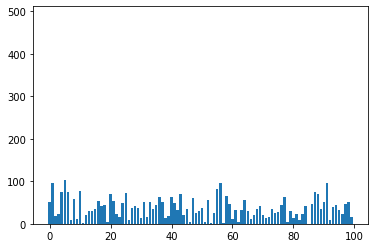

In [248]:
predictionslistSBOX = predictionsSBOX.tolist()
predictionslistSBOXflat = [item for sublist in predictionslistSBOX for item in sublist]

error_list_SBOX = []   #absolute waarde van de fout van predictie 
for error1, error2 in zip(predictionslistSBOXflat, delaypiekSBOXtest):
  error_list_SBOX.append(round(abs(error1 - error2)))

print(error_list_SBOX)
print(predictionslistSBOXflat)
print(delaypiekSBOXtest)
#visualiseren error
bar = plt.figure(3)
plt.bar(np.arange(0, 100), error_list_SBOX)
plt.ylim(0, 512)
plt.show()


MODEL VOOR ALLE DRIE DE SIGNALEN